In [25]:
import trafpy
import trafpy.generator as tpg

import os
import pickle
import matplotlib.pyplot as plt

path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/testbed_data/small_uniform_testbed_data.obj'
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())

dict_keys(['benchmark_data', 'benchmarks', 'envs', 'config'])


In [26]:
envs = tb_dict['envs']
print(envs)

[<trafpy.manager.src.simulators.dcn.DCN object at 0x7f2aea428790>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2aab8280a0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2ac28e5880>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a9d7ab7f0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2abe1029a0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a3f7701c0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a94ead0a0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a8b2ede50>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a465103a0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a10c69460>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a02e1d160>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a937d0eb0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a4a3497f0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f29f4fa90d0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7f2a95267a60>, <trafpy.m

## TODO

### Key Stats to Compare
- Average flow completion time
- 99th percentile flow completion time
- Queue length
- Throughput

### Key Plots

In [27]:
for env in envs:
    print('Net capacity: {}'.format(env.network.graph['max_nw_capacity']))
    print(env.get_scheduling_session_summary(print_summary=True))

Net capacity: 288.0
-=-=-=-=-=-=-= Scheduling Session Ended -=-=-=-=-=-=-=
SUMMARY:
~* General Info *~
Simulation name: 'benchmark_uniform_load_0.1_repeat_0_scheduler_srpt'
Total session duration: 5943000.0 time units
Total number of generated demands (jobs or flows): 4391
Total info arrived: 21865375.0 info units
Load: 11.4607698408706 info unit demands arrived per unit time (from first to last flow arriving)
Total info transported: 21865375.0 info units
Throughput: 3.6791813898704357 info units transported per unit time

~* Flow Info *~
Total number generated flows (src!=dst,dependency_type=='data_dep'): 4391
Time first flow arrived: 0.0 time units
Time last flow arrived: 1907845.2236275803 time units
Time first flow completed: 2000.0 time units
Time last flow completed: 5943000.0 time units
Total number of demands that arrived and became flows: 4391
Total number of flows that were completed: 4391
Total number of dropped flows + flows in queues at end of session: 0
Average FCT: 11375

-=-=-=-=-=-=-= Scheduling Session Ended -=-=-=-=-=-=-=
SUMMARY:
~* General Info *~
Simulation name: 'benchmark_uniform_load_1.0_repeat_0_scheduler_srpt'
Total session duration: 7508000.0 time units
Total number of generated demands (jobs or flows): 5844
Total info arrived: 29395049.0 info units
Load: 116.69241562400677 info unit demands arrived per unit time (from first to last flow arriving)
Total info transported: 29395049.0 info units
Throughput: 3.915163692061801 info units transported per unit time

~* Flow Info *~
Total number generated flows (src!=dst,dependency_type=='data_dep'): 5844
Time first flow arrived: 0.0 time units
Time last flow arrived: 251901.9667457518 time units
Time first flow completed: 1000.0 time units
Time last flow completed: 7508000.0 time units
Total number of demands that arrived and became flows: 5844
Total number of flows that were completed: 5844
Total number of dropped flows + flows in queues at end of session: 0
Average FCT: 2270627.1511231284 time u

In [28]:
# collect testbed stats into dict
testbed_stats = {'test_{}'.format(i): 
                 {envs[i].scheduler.scheduler_name: 
                  {'load_rate': envs[i].load, 
                   'load_frac': envs[i].load/envs[i].network.graph['max_nw_capacity'],
                   'avrg_fct': envs[i].avrg_fct,
                   'nn_fct': envs[i].nn_fct,
                   'q_dict': envs[i].queue_evolution_dict,
                   'throughput': envs[i].throughput}
                 } for i in range(len(envs))}

# find classes
classes = []
for test in testbed_stats.keys():
    for _class in testbed_stats[test].keys():
        if _class not in classes:
            classes.append(_class)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


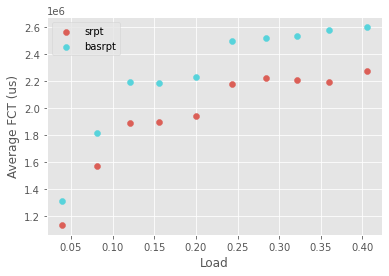

In [29]:
# avrg fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['load_frac'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['avrg_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='Load', ylabel='Average FCT (us)', show_fig=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


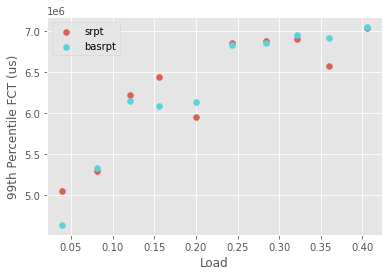

In [30]:
# 99th percentile fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['load_frac'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['nn_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='Load', ylabel='99th Percentile FCT (us)', show_fig=True)

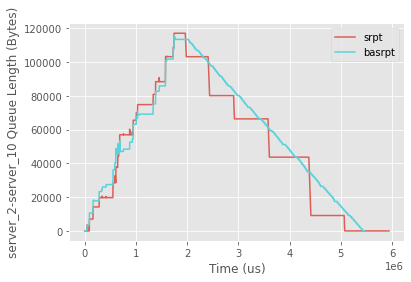

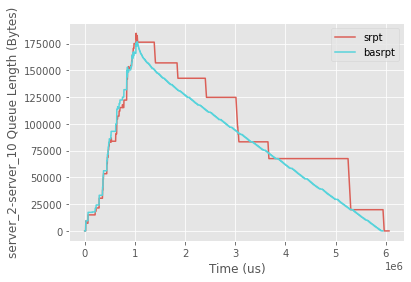

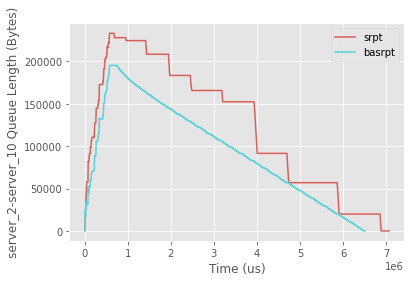

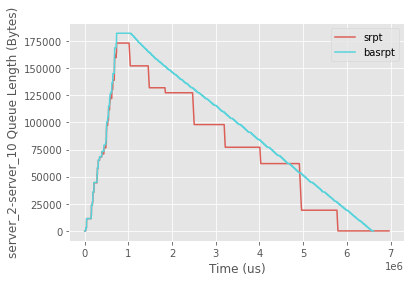

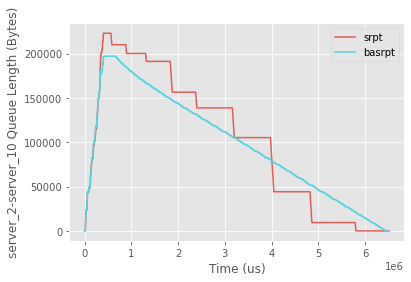

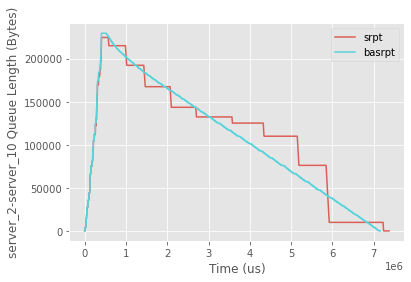

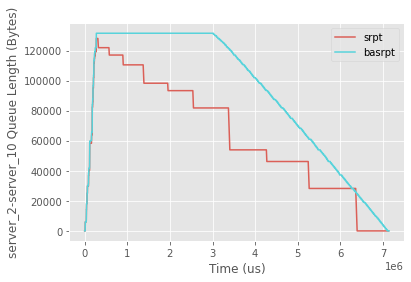

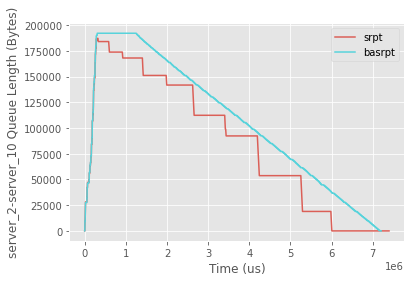

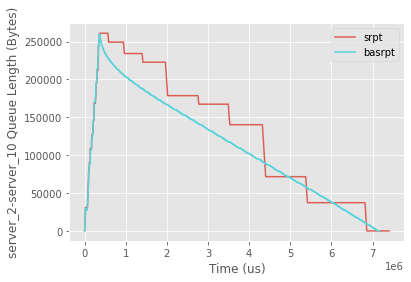

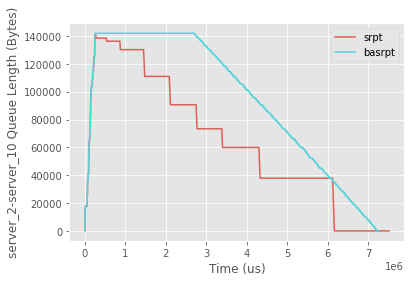

In [31]:
import numpy

# queue length
plot_dict = {}
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    try:
        plot_dict[load][_class]['x_values'] = None
        plot_dict[load][_class]['y_values'] = None
    except KeyError:
        # not yet added this load
        try:
            plot_dict[load][_class] = {}
            plot_dict[load][_class]['x_values'] = None
            plot_dict[load][_class]['y_values'] = None
        except KeyError:
            plot_dict[load] = {}
            plot_dict[load][_class] = {}
            plot_dict[load][_class]['x_values'] = None
            plot_dict[load][_class]['y_values'] = None

src = 'server_2'
dst='server_10'
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    plot_dict[load][_class]['x_values'] = testbed_stats[test][_class]['q_dict'][src][dst]['times'] 
    plot_dict[load][_class]['y_values'] = testbed_stats[test][_class]['q_dict'][src][dst]['queue_lengths']
    
for load in plot_dict.keys():
    tpg.plot_val_line(plot_dict=plot_dict[load],xlabel='Time (us)', ylabel='{}-{} Queue Length (Bytes)'.format(src,dst), show_fig=True)

{0.03979433972524514: {'x_values': ['s', 'b'], 'y_values': [3.6791813898704357, 4.00244828848618]}, 0.08089880125609254: {'x_values': ['s', 'b'], 'y_values': [4.008706726013847, 4.091673397274104]}, 0.1553796651335635: {'x_values': ['s', 'b'], 'y_values': [3.7442073602264685, 4.064038254724228]}, 0.1211509104129666: {'x_values': ['s', 'b'], 'y_values': [3.8441426930806775, 4.050566933898049]}, 0.20052964417066466: {'x_values': ['s', 'b'], 'y_values': [4.079884639016897, 4.103839462299135]}, 0.24337044015940215: {'x_values': ['s', 'b'], 'y_values': [3.985505493015055, 4.102349853413374]}, 0.35971544648995957: {'x_values': ['s', 'b'], 'y_values': [4.113652027501052, 4.1067373581734135]}, 0.32161191444938936: {'x_values': ['s', 'b'], 'y_values': [3.9866211793345956, 4.091765269294836]}, 0.2842848761260727: {'x_values': ['s', 'b'], 'y_values': [3.975492972972973, 4.105309517164387]}, 0.40518199869446797: {'x_values': ['s', 'b'], 'y_values': [3.915163692061801, 4.055048834321975]}}


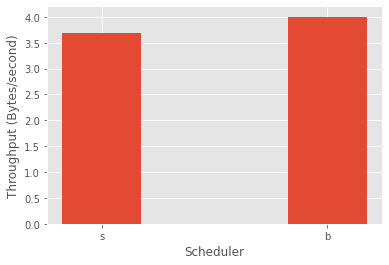

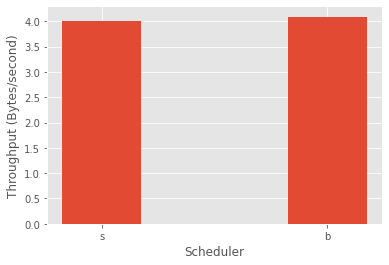

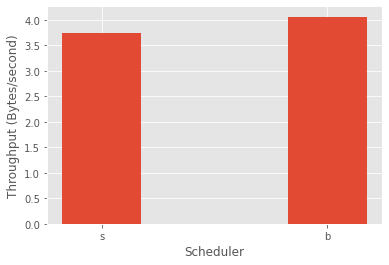

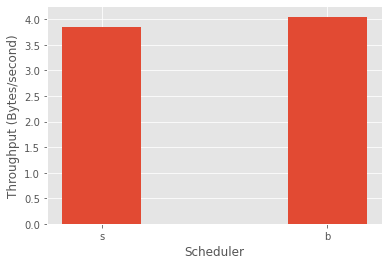

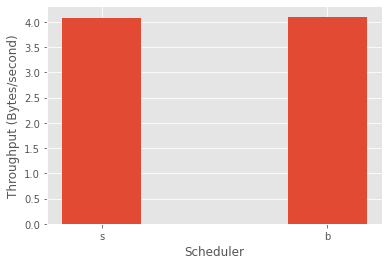

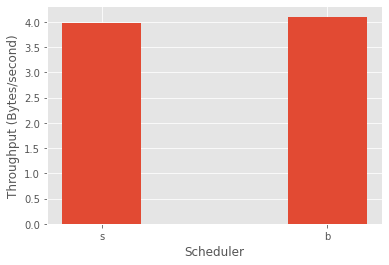

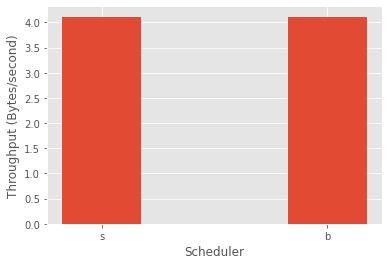

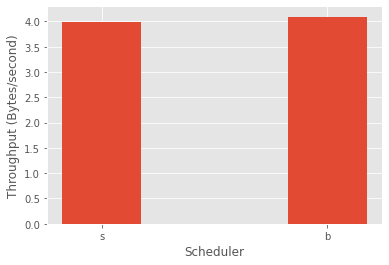

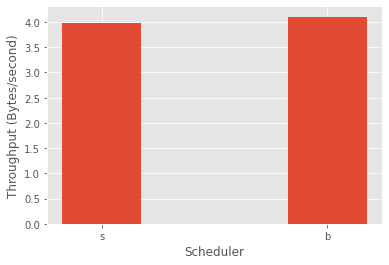

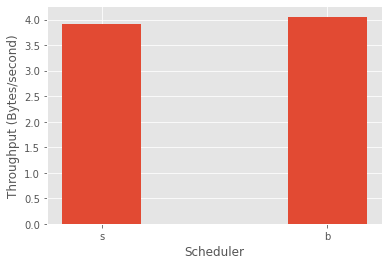

In [32]:
# throughput
plot_dict = {}
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    try:
        plot_dict[load]['x_values'].append(_class[0])
        plot_dict[load]['y_values'].append(testbed_stats[test][_class]['throughput'])
    except KeyError:
        try:
            plot_dict[load] = {}
            plot_dict[load]['x_values'].append(_class[0])
            plot_dict[load]['y_values'].append(testbed_stats[test][_class]['throughput'])
        except KeyError:
            plot_dict[load] = {}
            plot_dict[load]['x_values'] = []
            plot_dict[load]['y_values'] = []
            plot_dict[load]['x_values'].append(_class[0])
            plot_dict[load]['y_values'].append(testbed_stats[test][_class]['throughput'])
    
print(plot_dict)
for load in plot_dict.keys():
    tpg.plot_val_bar(x_values=plot_dict[load]['x_values'],y_values=plot_dict[load]['y_values'],xlabel='Scheduler', ylabel='Throughput (Bytes/second)', show_fig=True)